In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import os

In [2]:
print(os.listdir('chest_xray'))

print(len(os.listdir('chest_xray/NORMAL')))
print(len(os.listdir('chest_xray/PNEUMONIA')))

['balanced', 'NORMAL', 'PNEUMONIA']
1583
4273


In [3]:
base_dir = 'chest_xray'

## Balance the Dataset

In [5]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Set up paths to your dataset folders
data_dir = 'chest_xray'
normal_dir = os.path.join(data_dir, 'NORMAL')
pneumonic_dir = os.path.join(data_dir, 'PNEUMONIA')

# Count the number of images in each class
normal_images = os.listdir(normal_dir)
pneumonic_images = os.listdir(pneumonic_dir)

num_normal = len(normal_images)
num_pneumonic = len(pneumonic_images)

print(f'Number of Normal images: {num_normal}')
print(f'Number of Pneumonic images: {num_pneumonic}')

# Calculate the difference in number of images between classes
# We want to oversample the minority class (Normal)
target_num = max(num_normal, num_pneumonic)  # Target number of images per class

# Create a new directory for balanced data
balanced_dir = 'chest_xray/balanced/'
os.makedirs(balanced_dir, exist_ok=True)

# Copy all Pneumonic images to the balanced directory
shutil.copytree(pneumonic_dir, os.path.join(balanced_dir, 'PNEUMONIA'))

# Oversample the Normal class to match the number of Pneumonic images
normal_balanced_dir = os.path.join(balanced_dir, 'NORMAL')
os.makedirs(normal_balanced_dir, exist_ok=True)

# Randomly sample Normal images to match the target number
random_normal_images = random.choices(normal_images, k=target_num)

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation and copy augmented Normal images to balanced directory
for img_name in random_normal_images:
    src_path = os.path.join(normal_dir, img_name)
    img = load_img(src_path)  # Load the image

    # Convert image to numpy array
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate and save augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=normal_balanced_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= 3:  # Generate 3 augmented images per original image
            break

print(f'Balanced dataset created in: {balanced_dir}')


Number of Normal images: 1583
Number of Pneumonic images: 4273


KeyboardInterrupt: 

In [4]:
print(os.listdir('chest_xray/balanced'))

print(len(os.listdir('chest_xray/balanced/NORMAL')))
print(len(os.listdir('chest_xray/balanced/PNEUMONIA')))

['NORMAL', 'PNEUMONIA']
4756
4273


## DATA PREPROCESSING

(1248, 1604, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

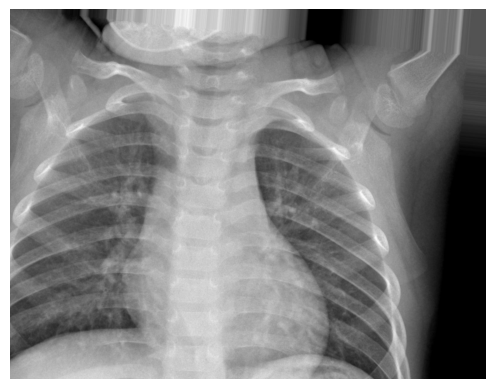

In [5]:
image_path= "D:/DL CB/chest_xray/balanced/NORMAL/aug_0_2.jpg"

#Read the image
img = mpimg.imread(image_path)

print(img.shape)
#displaying the image
plt.imshow(img,cmap='gray')
plt.axis('off') ## turn off the axis numbers
plt.show

In [6]:
img_size = 224
batch_size = 32

In [7]:
base_dir = 'chest_xray/balanced'

# Train Test Split

In [8]:
#Image data generator
data_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.2 #use 20% data for validation
)

In [9]:
#Image Data Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)

Found 7224 images belonging to 2 classes.


In [10]:
#Validation Generator
validation_generator =  data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 1805 images belonging to 2 classes.


# Convolutional Neural Network

In [11]:
num_classes = 2

In [12]:
#Model defination
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (img_size,img_size,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(num_classes,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [14]:
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
##training the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//batch_size, ##number of steps per epoch
    epochs = 15,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//batch_size
)

Epoch 1/15


225/225 [==============================] - 584s 3s/step - loss: 0.3166 - accuracy: 0.8739 - val_loss: 0.1485 - val_accuracy: 0.9425
Epoch 2/15
225/225 [==============================] - 347s 2s/step - loss: 0.1277 - accuracy: 0.9527 - val_loss: 0.1222 - val_accuracy: 0.9515
Epoch 3/15
225/225 [==============================] - 379s 2s/step - loss: 0.0924 - accuracy: 0.9638 - val_loss: 0.0730 - val_accuracy: 0.9743
Epoch 4/15
225/225 [==============================] - 360s 2s/step - loss: 0.0699 - accuracy: 0.9754 - val_loss: 0.0602 - val_accuracy: 0.9749
Epoch 5/15
225/225 [==============================] - 356s 2s/step - loss: 0.0533 - accuracy: 0.9804 - val_loss: 0.0813 - val_accuracy: 0.9704
Epoch 6/15
225/225 [==============================] - 2326s 10s/step - loss: 0.0371 - accuracy: 0.9880 - val_loss: 0.0543 - val_accuracy: 0.9810
Epoch 7/15
225/225 [==============================] - 349s 2s/step - loss: 0.0324 - accuracy: 0.9914 - val_loss: 0.0614 - val_accuracy: 0.

In [19]:
  #Model Evalution
print("Evaluating Model...")
val_loss, val_accuracy = model.evaluate(validation_generator,steps = validation_generator.samples //batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating Model...
56/56 [==============================] - 37s 668ms/step - loss: 0.0662 - accuracy: 0.9833
Validation Accuracy: 98.33%


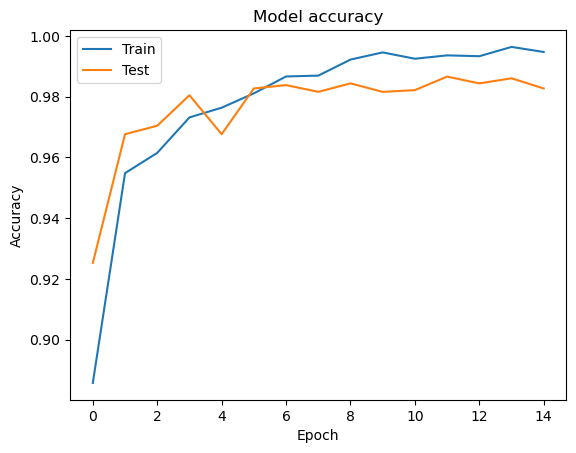

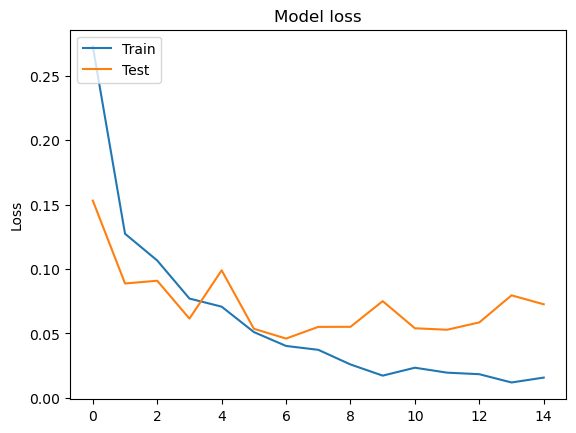

In [20]:
#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

#PLot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [18]:
model.save('D:/DL CB/ches_xray_model.h5')

C:\Users\prati\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from PIL import Image

In [22]:
#Function to load and preprocess the image using pillow
def load_and_preprocess_image(image_path,target_size=(224,224)):
  #load the image
  img = Image.open(image_path)
  #resize the image
  img = img.resize(target_size)
  #convert the image to a numpy array
  img_array = np.array(img)
  #add batch dimension
  img_array = np.expand_dims(img_array,axis=0)
  #Scale the image values to [0,1]
  img_array = img_array.astype('float32')/255.
  return img_array

#Function to predict the class of an image
def predict_image_class(model,image_path,class_indices):
  preprocessed_img = load_and_preprocess_image(image_path)
  predictions = model.predict(preprocessed_img)
  predicted_class_index = np.argmax(predictions,axis=1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [23]:
#create a mapping from class indices to class name
class_indices = {v:k for k,v in train_generator.class_indices.items()}

In [24]:
class_indices

{0: 'NORMAL', 1: 'PNEUMONIA'}

## Model Explanantion (XAI)

In [28]:
from lime import lime_image

In [29]:
x = 10
num_batches_to_skip = x // batch_size
for i in range(num_batches_to_skip):
    _ = next(validation_generator)

# Get the batch containing the desired image
X_val_batch, _ = next(validation_generator)

explanation = explainer.explain_instance(
    X_val_batch[x % batch_size],
    model.predict,
    top_labels=2
)

NameError: name 'explainer' is not defined